In [17]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "TNT LLM"
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [18]:
import logging
import operator
from typing import Annotated, List, Optional
from typing_extensions import TypedDict

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("tnt-llm")


class Doc(TypedDict):
    id: str
    content: str
    summary: Optional[str]
    explanation: Optional[str]
    category: Optional[str]


class TaxonomyGenerationState(TypedDict):
    # The raw docs; we inject summaries within them in the first step
    documents: List[Doc]
    # Indices to be concise
    minibatches: List[List[int]]
    # Candidate Taxonomies (full trajectory)
    clusters: Annotated[List[List[dict]], operator.add]

In [19]:
import re 

from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough

summary_prompt = hub.pull("wfh/tnt-llm-summary-generation").partial(
    summary_length=20, explanation_length=30
)

def parse_summary(xml_string: str) -> dict:
    summary_pattern = r"<summary>(.*?)</summary>"
    explanation_pattern = r"<explanation>(.*?)</explanation>"

    summary_match = re.search(summary_pattern, xml_string, re.DOTALL)
    explanation_match = re.search(explanation_pattern, xml_string, re.DOTALL)

    summary = summary_match.group(1).strip() if summary_match else ""
    explanation = explanation_match.group(1).strip() if explanation_match else ""

    return {"summary": summary, "explanation": explanation}
    
summary_llm_chain = (
    summary_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
).with_config(run_name="GenerateSummary")
summary_chain = summary_llm_chain | parse_summary

# Now combine as a "map" operation in a map-reduce chain
# Input: state
# Output: state U summaries
# Processes docs in parallel
def get_content(state: TaxonomyGenerationState): 
    docs = state["documents"]
    return [{"content": doc["content"]} for doc in docs]

map_step = RunnablePassthrough.assign(
    summaries=get_content | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)
)

def reduce_summaries(combined: dict) -> TaxonomyGenerationState:
    summaries = combined["summaries"]
    documents = combined["documents"]
    return {
        "documents": [
            {
                "id": doc["id"],
                "content": doc["content"],
                "summary": summ_info["summary"],
                "explanation": summ_info["explanation"],
            }
            for doc, summ_info in zip(documents, summaries)
        ]
    }

map_reduce_chain = map_step | reduce_summaries

In [20]:
import random

def get_minibatches(state: TaxonomyGenerationState, config: RunnableConfig):
    batch_size = config["configurable"].get("batch_size", 200)
    original = state["documents"]
    indices = list(range(len(original)))
    random.shuffle(indices)
    if len(indices) < batch_size:
        return [indices]

    num_full_batches = len(indices) // batch_size
    
    batches = [
        indices[i * batch_size: (i + 1) * batch_size] for i in range(num_full_batches)
    ]
    leftovers = len(indices) % batch_size
    if leftovers:
        last_batch = indices[num_full_batches * batch_size :]
        elements_to_add = batch_size - leftovers
        last_batch += random.sample(indices, elements_to_add)
        batches.append(last_batch)
        
    return {
        "minibatches": batches,
    }

In [6]:
from typing import Dict

from langchain_core.runnables import Runnable

def parse_taxa(output_text: str) -> Dict:
    """Extract the taxonomy from the generated output."""
    cluster_matches = re.findall(
        r"\s*<id>(.*?)</id>\s*<name>(.*?)</name>\s*<description>(.*?)</description>\s*",
        output_text,
        re.DOTALL,
    )
    clusters = [
        {"id": id.strip(), "name": name.strip(), "description": description.strip()}
        for id, name, description in cluster_matches
    ]
    # We don't parse the explanation since it isn't used downstream
    return {"clusters": clusters}

def format_docs(docs: List[Doc]) -> str:
    xml_table = "<conversations>\n"
    for doc in docs:
        xml_table += f'<conv_summ id={doc["id"]}>{doc["summary"]}</conv_summ>\n'
    xml_table += "</conversations>"
    return xml_table

def format_taxonomy(clusters):
    xml = "<cluster_table>\n"
    for label in clusters:
        xml += "  <cluster>\n"
        xml += f'    <id>{label["id"]}</id>\n'
        xml += f'    <name>{label["name"]}</name>\n'
        xml += f'    <description>{label["description"]}</description>\n'
        xml += "  </cluster>\n"
    xml += "</cluster_table>"
    return xml

def invoke_taxonomy_chain(
    chain: Runnable,
    state: TaxonomyGenerationState,
    config: RunnableConfig,
    mb_indices: List[int],
) -> TaxonomyGenerationState:
    configurable = config["configurable"]
    docs = state["documents"]
    minibatch = [docs[idx] for idx in mb_indices]
    data_table_xml = format_docs(minibatch)

    previous_taxonomy = state["clusters"][-1] if state["clusters"] else []
    cluster_table_xml = format_taxonomy(previous_taxonomy)

    updated_taxonomy = chain.invoke(
        {
            "data_xml": data_table_xml,
            "use_case": configurable["use_case"],
            "cluster_table_xml": cluster_table_xml,
            "suggestion_length": configurable.get("suggestion_length", 30),
            "cluster_name_length": configurable.get("cluster_name_length", 10),
            "cluster_description_length": configurable.get(
                "cluster_description_length", 30
            ),
            "explanation_length": configurable.get("explanation_length", 20),
            "max_num_clusters": configurable.get("max_num_clusters", 25),
        }
    )

    return {
        "clusters": [updated_taxonomy["clusters"]],
    }

In [21]:
# We will share an LLM for each step of the generate -> update -> review cycle
# You may want to consider using Opus or another more powerful model for this
taxonomy_generation_llm = ChatOpenAI(
    model="gpt-4o-mini", max_tokens_to_sample=2000
)


## Initial generation
taxonomy_generation_prompt = hub.pull("wfh/tnt-llm-taxonomy-generation").partial(
    use_case="Generate the taxonomy that can be used to label the user intent in the conversation.",
)

taxa_gen_llm_chain = (
    taxonomy_generation_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="GenerateTaxonomy")


generate_taxonomy_chain = taxa_gen_llm_chain | parse_taxa


def generate_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    return invoke_taxonomy_chain(
        generate_taxonomy_chain, state, config, state["minibatches"][0]
    )

/Users/admin/miniconda3/envs/langgraph/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: UserWarning: WARNING! max_tokens_to_sample is not default parameter.
                max_tokens_to_sample was transferred to model_kwargs.
                Please confirm that max_tokens_to_sample is what you intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
taxonomy_update_prompt = hub.pull("wfh/tnt-llm-taxonomy-update")

taxa_update_llm_chain = (
    taxonomy_update_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="UpdateTaxonomy")

update_taxonomy_chain = taxa_update_llm_chain | parse_taxa

def update_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    which_mb = len(state["clusters"]) % len(state["minibatches"])
    return invoke_taxonomy_chain(
        update_taxonomy_chain, state, config, state["minibatches"][which_mb]
    )

In [23]:
taxonomy_review_prompt = hub.pull("wfh/tnt-llm-taxonomy-review")

taxa_review_llm_chain = (
    taxonomy_review_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name="ReviewTaxonomy")


review_taxonomy_chain = taxa_review_llm_chain | parse_taxa


def review_taxonomy(
    state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    batch_size = config["configurable"].get("batch_size", 200)
    original = state["documents"]
    indices = list(range(len(original)))
    random.shuffle(indices)
    return invoke_taxonomy_chain(
        review_taxonomy_chain, state, config, indices[:batch_size]
    )

In [24]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(TaxonomyGenerationState)
graph.add_node("summarize", map_reduce_chain)
graph.add_node("get_minibatches", get_minibatches)
graph.add_node("generate_taxonomy", generate_taxonomy)
graph.add_node("update_taxonomy", update_taxonomy)
graph.add_node("review_taxonomy", review_taxonomy)

graph.add_edge("summarize", "get_minibatches")
graph.add_edge("get_minibatches", "generate_taxonomy")
graph.add_edge("generate_taxonomy", "update_taxonomy")


def should_review(state: TaxonomyGenerationState) -> str:
    num_minibatches = len(state["minibatches"])
    num_revisions = len(state["clusters"])
    if num_revisions < num_minibatches:
        return "update_taxonomy"
    return "review_taxonomy"


graph.add_conditional_edges(
    "update_taxonomy",
    should_review,
    # Optional (but required for the diagram to be drawn correctly below)
    {"update_taxonomy": "update_taxonomy", "review_taxonomy": "review_taxonomy"},
)
graph.add_edge("review_taxonomy", END)

graph.add_edge(START, "summarize")
app = graph.compile()

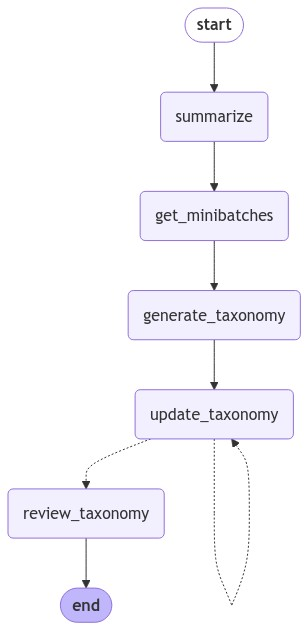

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
from datetime import datetime, timedelta

from langsmith import Client

project_name = "Web STORM"  # Update to your own project
client = Client()

past_week = datetime.now() - timedelta(days=7)
runs = list(
    client.list_runs(
        project_name=project_name,
        filter="eq(is_root, true)",
        start_time=past_week,
        # We only need to return the inputs + outputs
        select=["inputs", "outputs"],
    )
)


# Convert the langsmith traces to our graph's Doc object.
def run_to_doc(run) -> Doc:
    turns = []
    idx = 0
    for turn in run.inputs.get("chat_history") or []:
        key, value = next(iter(turn.items()))
        turns.append(f"<{key} idx={idx}>\n{value}\n</{key}>")
        idx += 1
    turns.append(
        f"""
<human idx={idx}>
{run.inputs['question']}
</human>"""
    )
    if run.outputs and run.outputs["output"]:
        turns.append(
            f"""<ai idx={idx+1}>
{run.outputs['output']}
</ai>"""
        )
    return {
        "id": str(run.id),
        "content": ("\n".join(turns)),
    }

In [27]:
from langchain.cache import InMemoryCache
from langchain.globals import set_llm_cache

set_llm_cache(InMemoryCache())

In [29]:
docs = [run_to_doc(run) for run in runs if run.inputs]
docs = random.sample(docs, min(len(docs), 1000))
use_case = (
    "Generate the taxonomy that can be used to label the user intent"
    " as well as to identify any required documentation (references, how-tos, etc.)"
    " that would benefit the user."
)
stream = app.stream(
    {"documents": docs},
    {
        "configurable": {
            "use_case": use_case,
            # Optional:
            "batch_size": 400,
            "suggestion_length": 30,
            "cluster_name_length": 10,
            "cluster_description_length": 30,
            "explanation_length": 20,
            "max_num_clusters": 25,
        },
        # We batch summarize the docs. To avoid getting errors, we will limit the
        # degree of parallelism to permit.
        "max_concurrency": 2,
    },
)

for step in stream:
    node, state = next(iter(step.items()))
    print(node, str(state)[:20] + " ...")

KeyError: 'question'